In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd  
import seaborn as sns 
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from yellowbrick.cluster.elbow import kelbow_visualizer
from yellowbrick.cluster import silhouette_visualizer
import pickle

### Leidinių duomenų rinkinio sutvarkymas

In [2]:
leidiniai = pd.read_csv('leidiniai.csv')

In [3]:
leidiniai

,Unnamed: 0,journal_number,journal_name,journal_name_in_foreign_language_1,journal_name_in_foreign_language_2,journal_name_in_foreign_language_3,scopus_sources,SNIP,CiteScore,SJR,quartile_in_caterory,IF,AIF,quartile_in_caterory_2,if_info_years,InCites_JCR,final_index
0,0,10.0,Verslas: teorija ir praktika,NaN,NaN,NaN,2009.0,0.455,NaN,0.380,NaN,NaN,NaN,NaN,NaN,NaN,1298.0
1,1,18.0,Journal of environmental engineering and lands...,NaN,NaN,NaN,2010.0,1.062,NaN,0.440,NaN,1.333,2.496,Q3,2010.0,SCIE,94.0
2,2,NaN,Vandens ūkio inžinerija,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1295.0
3,3,NaN,Socialinių mokslų studijos,Social sciences studies: mokslo darbai,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,430.0
4,4,11.0,Verslas: teorija ir praktika,Business: theory and practice,NaN,NaN,2010.0,0.630,NaN,0.360,NaN,NaN,NaN,NaN,NaN,NaN,1298.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7508,7508,2.0,Miškininkystė,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1037.0
7509,7509,NaN,Проект Балтия,Project Baltia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,476.0
7510,7510,NaN,Проект Балтия,Project Baltia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,476.0
7511,7511,26.0,Materials science,Medžiagotyra,NaN,NaN,2018.0,0.340,0.59,0.206,Q3,0.636,4.951,Q4,2018.0,SCIE,23.0


#### Pirmu žingsniu pašalinamos eilutės, kuriose nėra leidinių rodiklių

In [4]:
leidiniai_2 = leidiniai.dropna(subset=['scopus_sources', 'IF'], how='all')

#### Sukuriama atskira DataFrame su leidiniais, kurie neturi rodiklių

In [5]:
leidiniai_be_rodiklių = leidiniai.drop(leidiniai_2.index)

#### Palyginama, kiek leidinių buvo iš viso ir kiek jų buvo galima klasterizuoti, ir kiek - ne

In [6]:
pasalinti = np.count_nonzero(leidiniai_be_rodiklių['final_index'].unique())

In [7]:
tinkami = np.count_nonzero(leidiniai_2['final_index'].unique())

In [8]:
visi = pasalinti + tinkami

In [9]:
print("Žurnalai, kurių nebuvo galima klasterizuoti ", round((pasalinti / visi)*100,2), '%')

Žurnalai, kurių nebuvo galima klasterizuoti  50.35 %


In [10]:
print("Žurnalai, kurie buvo klasterizuojami", round((tinkami / visi)*100,2), '%')

Žurnalai, kurie buvo klasterizuojami 49.65 %


### Sutvarkomas gautas duomenų rinkinys

#### 1. Pašalinami neinformatyvūs stulpeliai

In [11]:
leidiniai_2 = leidiniai_2.drop(['Unnamed: 0', 'journal_number', 'journal_name_in_foreign_language_1',
                               'journal_name_in_foreign_language_2',
                               'journal_name_in_foreign_language_3'], axis=1)

#### 2. NaN reikšmės pakeičiamos į 0, str reikšmės paverčiamos į int ir pašalinami dublikatai

In [12]:
leidiniai_2 = leidiniai_2.fillna(0)

In [13]:
leidiniai_2[['scopus_sources', 'if_info_years', 'final_index']] = leidiniai_2[['scopus_sources', 'if_info_years', 'final_index']].astype('int')

In [14]:
leidiniai_2 = leidiniai_2.drop_duplicates()

#### 3. Sukuriama nauja DataFrame tik Scopus rodikliams. Naudojantis pivot table funkcija, duomenys pergrupuojami, kad metai taptų stulpeliais, o rodikliai - eilutėmis. Tai daroma kiekvienam rodikliui atskirai ir galiausiai sukuriama viena DataFrame 

In [15]:
leidiniai_3 = leidiniai_2[['final_index', 'scopus_sources', 'SNIP', 'CiteScore', 'SJR', 'quartile_in_caterory']]

In [16]:
quartile_in_caterory = leidiniai_3['quartile_in_caterory'].str.split('Q', expand=True)

In [17]:
leidiniai_3 = leidiniai_3.drop(['quartile_in_caterory'], axis=1)

In [18]:
leidiniai_3['quartile_in_caterory'] = quartile_in_caterory[1].fillna(0).astype(int)

##### SNIP

In [19]:
leidiniai_3_SNIP = leidiniai_3.pivot_table(index="final_index", columns="scopus_sources", values='SNIP')

In [20]:
leidiniai_3_SNIP = leidiniai_3_SNIP.add_suffix('_SNIP')

In [21]:
leidiniai_3_SNIP=leidiniai_3_SNIP.reset_index()

In [22]:
leidiniai_3_SNIP = leidiniai_3_SNIP.drop(['0_SNIP'], axis=1)

##### CiteScore

In [23]:
leidiniai_3_CiteScore = leidiniai_3.pivot_table(index="final_index", columns="scopus_sources", values='CiteScore')

In [24]:
leidiniai_3_CiteScore = leidiniai_3_CiteScore.add_suffix('_CiteScore')

In [25]:
leidiniai_3_CiteScore=leidiniai_3_CiteScore.reset_index()

In [26]:
leidiniai_3_CiteScore = leidiniai_3_CiteScore.drop(['0_CiteScore'], axis=1)

##### SJR

In [27]:
leidiniai_3_SJR = leidiniai_3.pivot_table(index="final_index", columns="scopus_sources", values='SJR')

In [28]:
leidiniai_3_SJR = leidiniai_3_SJR.add_suffix('_SJR')

In [29]:
leidiniai_3_SJR=leidiniai_3_SJR.reset_index()

In [30]:
leidiniai_3_SJR = leidiniai_3_SJR.drop(['0_SJR'], axis=1)

##### quartile_in_caterory

In [31]:
leidiniai_3_quartile_in_caterory = leidiniai_3.pivot_table(index="final_index", columns="scopus_sources", values='quartile_in_caterory')

In [32]:
leidiniai_3_quartile_in_caterory = leidiniai_3_quartile_in_caterory.round(0)

In [33]:
leidiniai_3_quartile_in_caterory = leidiniai_3_quartile_in_caterory.add_suffix('_scopus_quartile')

In [34]:
leidiniai_3_quartile_in_caterory=leidiniai_3_quartile_in_caterory.reset_index()

In [35]:
leidiniai_3_quartile_in_caterory = leidiniai_3_quartile_in_caterory.drop(['0_scopus_quartile'], axis=1)

##### Scopus DataFrame

In [36]:
leidiniai_scopus = pd.merge(pd.merge(pd.merge(leidiniai_3_SNIP,leidiniai_3_CiteScore,on='final_index'),
                            leidiniai_3_SJR,on='final_index'),leidiniai_3_quartile_in_caterory,on='final_index')

#### 4. Žingsniai atkartojami IF rodikliams

In [37]:
leidiniai_4 = leidiniai_2[['final_index', 'IF', 'AIF', 'quartile_in_caterory_2', 'if_info_years']]

In [38]:
quartile_in_caterory_2 = leidiniai_4['quartile_in_caterory_2'].str.split('Q', expand=True)

In [39]:
leidiniai_4 = leidiniai_4.drop(['quartile_in_caterory_2'], axis=1)

In [40]:
leidiniai_4['quartile_in_caterory_2'] = quartile_in_caterory_2[1].fillna(0).astype(int)

##### IF

In [41]:
leidiniai_4_IF = leidiniai_4.pivot_table(index="final_index", columns="if_info_years", values='IF')

In [42]:
leidiniai_4_IF = leidiniai_4_IF.add_suffix('_IF')

In [43]:
leidiniai_4_IF=leidiniai_4_IF.reset_index()

In [44]:
leidiniai_4_IF = leidiniai_4_IF.drop(['0_IF'], axis=1)

##### AIF

In [45]:
leidiniai_4_AIF = leidiniai_4.pivot_table(index="final_index", columns="if_info_years", values='AIF')

In [46]:
leidiniai_4_AIF = leidiniai_4_AIF.add_suffix('_AIF')

In [47]:
leidiniai_4_AIF=leidiniai_4_AIF.reset_index()

In [48]:
leidiniai_4_AIF = leidiniai_4_AIF.drop(['0_AIF'], axis=1)

##### quartile_in_caterory

In [49]:
leidiniai_4_quartile_in_caterory = leidiniai_4.pivot_table(index="final_index", columns="if_info_years", values='quartile_in_caterory_2')

In [50]:
leidiniai_4_quartile_in_caterory = leidiniai_4_quartile_in_caterory.round(0)

In [51]:
leidiniai_4_quartile_in_caterory = leidiniai_4_quartile_in_caterory.add_suffix('_IF_quartile')

In [52]:
leidiniai_4_quartile_in_caterory=leidiniai_4_quartile_in_caterory.reset_index()

In [53]:
leidiniai_4_quartile_in_caterory = leidiniai_4_quartile_in_caterory.drop(['0_IF_quartile'], axis=1)

##### IF DataBase

In [54]:
leidiniai_if = pd.merge(pd.merge(leidiniai_4_IF,leidiniai_4_AIF,on='final_index'),
                            leidiniai_4_quartile_in_caterory,on='final_index')

#### 5. Sujungiamos abi rodiklių lentelės į vieną ir pridedami likę rodikliai

In [55]:
leidiniai_rodikliai = pd.merge(leidiniai_scopus,leidiniai_if,on='final_index')

In [56]:
kiti_rodikliai = leidiniai_2[['final_index', 'InCites_JCR']]

In [57]:
kiti_rodikliai = kiti_rodikliai.drop_duplicates(subset=['final_index'])

In [58]:
leidiniai_final = pd.merge(leidiniai_rodikliai,kiti_rodikliai,on='final_index')

In [59]:
leidiniai_final['InCites_JCR'] = leidiniai_final['InCites_JCR'].replace([0], 'NA')

In [60]:
leidiniai_final = leidiniai_final.sort_values(by=['InCites_JCR'])

In [61]:
leidiniai_final

,final_index,2009_SNIP,2010_SNIP,2011_SNIP,2012_SNIP,2013_SNIP,2014_SNIP,2015_SNIP,2016_SNIP,2017_SNIP,...,2010_IF_quartile,2011_IF_quartile,2012_IF_quartile,2013_IF_quartile,2014_IF_quartile,2015_IF_quartile,2016_IF_quartile,2017_IF_quartile,2018_IF_quartile,InCites_JCR
322,709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NA
553,1146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NA
552,1145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NA
551,1141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.269,0.5970,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NA
111,216,NaN,0.271,0.634,NaN,0.827,1.017,0.788,0.603,1.4855,...,NaN,NaN,NaN,4.0,NaN,4.0,4.0,4.0,3.0,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.182,1.8400,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,SSCI
79,133,NaN,NaN,0.622,0.772,0.653,1.215,1.110,1.078,NaN,...,NaN,4.0,3.0,3.0,2.0,2.0,2.0,NaN,3.0,SSCI
502,1058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,SSCI
82,137,NaN,NaN,0.547,0.534,0.452,0.434,0.285,0.396,0.5280,...,NaN,4.0,4.0,3.0,4.0,4.0,4.0,3.0,3.0,SSCI


#### Sukuriama atskira DataFrame, kuri bus naudojama Flask app modeliui sudaryti. Parenkamos visų rodiklių paskutiniųjų metų reikšmės ir mokslo šaka – SCIE

In [63]:
test_data_for_flask = leidiniai_final[['2018_SNIP', '2018_CiteScore', '2018_SJR', 
                                       '2018_scopus_quartile', '2018_AIF', 
                                       '2018_IF_quartile']].loc[leidiniai_final['InCites_JCR'] == 'SCIE'].fillna(0)

#### 6. Sudaromi 3 duomenų rinkiniai pagal mokslo šakas: SCIE, SSCI ir NA

In [67]:
NA = leidiniai_final[leidiniai_final['InCites_JCR'] == 'NA']

In [68]:
NA = NA.drop(['InCites_JCR', 'final_index'], axis=1)

In [69]:
SCIE = leidiniai_final[leidiniai_final['InCites_JCR'] == 'SCIE']

In [70]:
SCIE = SCIE.drop(['InCites_JCR', 'final_index'], axis=1)

In [71]:
SSCI = leidiniai_final[leidiniai_final['InCites_JCR'] == 'SSCI']

In [72]:
SSCI = SSCI.drop(['InCites_JCR', 'final_index'], axis=1)

### Klasterizavimas

#### Duomenų scalinimas

In [73]:
scaler = MinMaxScaler()

In [74]:
scaled_data_NA = scaler.fit_transform(NA)

c:\users\ruta\desktop\studijos\4 semestras\02. python\venv\lib\site-packages\sklearn\preprocessing\_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
c:\users\ruta\desktop\studijos\4 semestras\02. python\venv\lib\site-packages\sklearn\preprocessing\_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [75]:
scaled_data_NA = pd.DataFrame(scaled_data_NA)

In [76]:
scaled_data_SCIE = scaler.fit_transform(SCIE)

c:\users\ruta\desktop\studijos\4 semestras\02. python\venv\lib\site-packages\sklearn\preprocessing\_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
c:\users\ruta\desktop\studijos\4 semestras\02. python\venv\lib\site-packages\sklearn\preprocessing\_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [77]:
scaled_data_SCIE = pd.DataFrame(scaled_data_SCIE)

In [78]:
scaled_data_SSCI = scaler.fit_transform(SSCI)

c:\users\ruta\desktop\studijos\4 semestras\02. python\venv\lib\site-packages\sklearn\preprocessing\_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
c:\users\ruta\desktop\studijos\4 semestras\02. python\venv\lib\site-packages\sklearn\preprocessing\_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [79]:
scaled_data_SSCI = pd.DataFrame(scaled_data_SSCI)

In [80]:
scaled_data = pd.concat([scaled_data_NA, scaled_data_SCIE, scaled_data_SSCI], axis=0, ignore_index=True)

In [81]:
scaled_data = scaled_data.fillna(0)

In [82]:
test_data = scaled_data.iloc[[0]]

In [83]:
test_data

,0,1,2,3,4,5,6,7,8,9,...,57,58,59,60,61,62,63,64,65,66
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025624,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Sukuriamas Kmeans modelis

In [84]:
km = KMeans()

In [85]:
km.fit(scaled_data)

KMeans()

#### Gauto modelio rezultatai nebūtinai yra geriausi iš pirmojo karto ir svarbu įsitikinti ar klasterių skaičius parinktas teisingai. Šiai užduočiai atlikti buvo naudojami 3 metodai: 
1.	Sudarant klasterių kvadratinės paklaidos sumos mažėjimo ir klasterių tarpusavio ryšio grafiką;
2.	Naudojant Python sistemoje jau paruoštą matodą kelbow_visualizer iš yellowbrick.cluster.elbow bibliotekos;
3.	Apskaičiuojant silueto koeficientą.


#### Klasterių kvadratinės paklaidos sumos mažėjimo ir klasterių tarpusavio ryšio grafikas

In [86]:
k_values = list(range(2,20))

In [87]:
inertias = []

In [88]:
for k in k_values:
    km = KMeans(n_clusters=k)
    km.fit(scaled_data)
    inertias.append(km.inertia_)

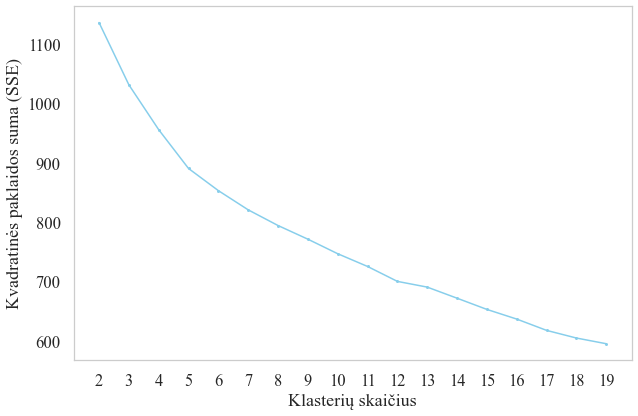

In [89]:
sns.set_theme(style="whitegrid", font_scale=1.5, font="Times New Roman")
f, ax = plt.subplots(figsize=(10, 6.5))
ax.grid(False)
plt.plot(k_values, inertias, marker='.',color='skyblue')
plt.xticks(k_values)
plt.xlabel('Klasterių skaičius')
plt.ylabel('Kvadratinės paklaidos suma (SSE)');

#### kelbow_visualizer

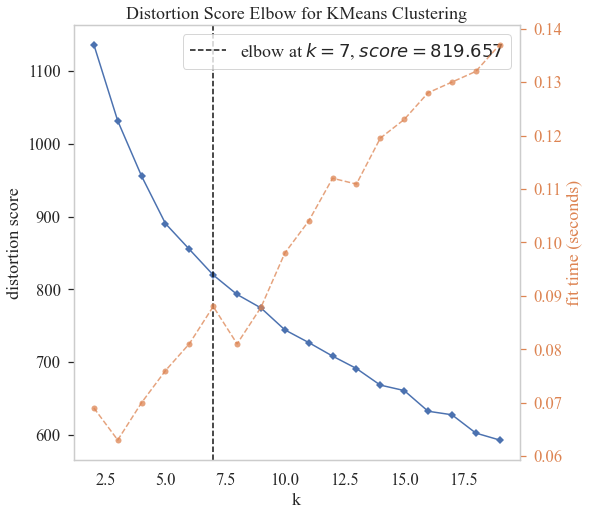

In [90]:
sns.set_theme(style="whitegrid", font_scale=1.5, font="Times New Roman")
f, ax = plt.subplots(figsize=(8,8))
ax.grid(False)

viz = kelbow_visualizer(KMeans(), scaled_data, k=(2, 20), show=False, random_state=43)

#### Silueto koeficientas

In [91]:
klasteriai = list(range(2,21))

In [92]:
score = []

In [93]:
for i in klasteriai:
    km = KMeans(n_clusters=i, random_state=42)
    km.fit(scaled_data)
    s = round(silhouette_score(scaled_data, km.labels_, metric='euclidean'),3)
    score.append(s)

In [94]:
klasteriu_vertinimas = pd.DataFrame(
    {'Klasteriu_skaicius': klasteriai,
     'silhouette_score': score
    })

In [95]:
klasteriu_vertinimas

,Klasteriu_skaicius,silhouette_score
0,2,0.386
1,3,0.124
2,4,0.128
3,5,0.144
4,6,0.108
5,7,0.152
6,8,0.124
7,9,0.136
8,10,0.141
9,11,0.152


#### Iš gautų rezultatų, priimamas sprendimas, kad optimalus klasterių skaičius yra 7

#### Optimaliausias klasterių skaičius pritaikomas modeliui

In [96]:
km = KMeans(n_clusters=7, random_state=43)

In [97]:
km.fit(scaled_data)

KMeans(n_clusters=7, random_state=43)

#### Klasterių reikšmės pridedamos prie duomenų lentelės

In [98]:
leidiniai_final['clusters'] = km.labels_

#### Pritaikomas PCA metodas duomenims vaizduoti

In [99]:
pca = PCA(random_state = 42)

In [100]:
pca_transformed_data = pd.DataFrame(pca.fit_transform(scaled_data))

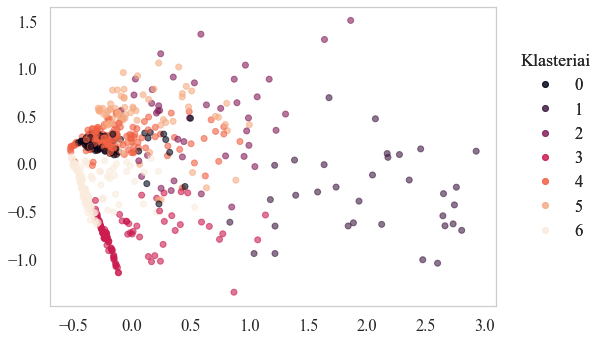

In [101]:
sns.set_theme(style="whitegrid", font_scale=1.5, font="Times New Roman")
fig, ax = plt.subplots()
ax.grid(False)
scatter = ax.scatter(pca_transformed_data[0], pca_transformed_data[1], c=leidiniai_final['clusters'], alpha = 0.6)

legend1 = ax.legend(*scatter.legend_elements(),
                    title="Klasteriai", loc=(1.04,0.2))
ax.add_artist(legend1);

### Klasterių analizė

#### Klasteriai vizualizuojami naudojantis silhouette_visualizer

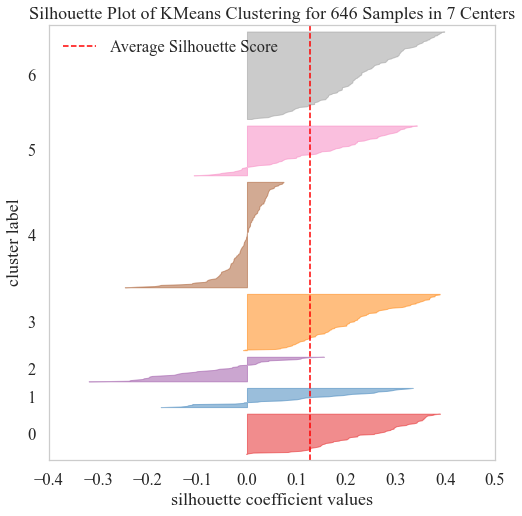

In [102]:
sns.set_theme(style="whitegrid", font_scale=1.5, font="Times New Roman")
f, ax = plt.subplots(figsize=(8, 8))
ax.grid(False)
silhouette_visualizer(KMeans(7, random_state=43), scaled_data, show=True);

#### Gauti klasteriai pridedami prie pradinio duomenų rinkinio ir apibūdinami

In [103]:
klasteriu_dydis = pd.DataFrame(leidiniai_final.clusters.value_counts()).sort_index().rename(columns = {'clusters':'count'})

In [104]:
klasteriai = leidiniai_final[['final_index', 'clusters']]

In [105]:
klasteriu_analize = pd.merge(leidiniai_2, klasteriai, on='final_index')

#### Analizuojami gautų klasterių rodikliai

In [106]:
vidurkiai_1 = klasteriu_analize.groupby('clusters').mean()

In [107]:
vidurkiai_1 = vidurkiai_1.drop(['scopus_sources', 'if_info_years', 'final_index'], axis=1).reset_index()

In [108]:
vidurkiai = vidurkiai_1.join(klasteriu_dydis)

In [109]:
vidurkiai_lentele = vidurkiai.round(2).rename(columns = {'clusters':'Klasteriai', 'count':'Žurnalų skaičius'})

In [110]:
vidurkiai_lentele

,Klasteriai,SNIP,CiteScore,SJR,IF,AIF,Žurnalų skaičius
0,0,1.06,1.60,0.67,1.40,2.38,68
1,1,0.74,0.85,0.38,0.79,1.96,33
2,2,1.50,2.63,1.01,2.26,2.25,42
3,3,0.77,1.18,0.41,1.04,2.94,95
4,4,0.73,0.85,0.48,0.81,1.35,177
5,5,1.02,1.80,0.70,1.62,2.71,84
6,6,1.20,2.75,0.90,2.34,2.33,147


In [111]:
#groupedvalues=vidurkiai.groupby('clusters').mean().reset_index()

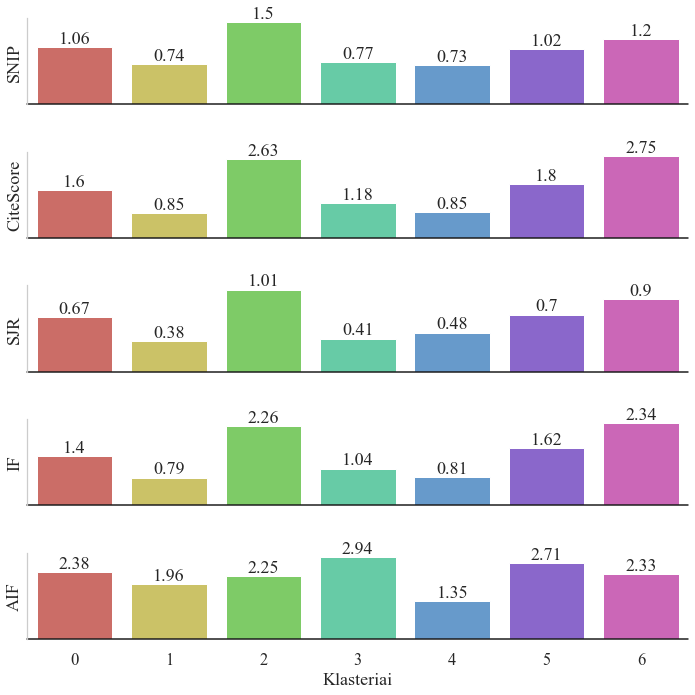

In [112]:
sns.set_theme(style="whitegrid", font_scale=1.5, font="Times New Roman")
rs = np.random.RandomState(8)

# Set up the matplotlib figure
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(10,10), sharex=True)

# SNIP
x = vidurkiai['clusters']
y1 = vidurkiai['SNIP']
sns.barplot(x=x, y=y1, palette="hls", ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("SNIP")
ax1.get_xaxis().set_visible(False)
labels1 = vidurkiai_lentele['SNIP'].tolist()
for i in ax1.containers:
    ax1.bar_label(i,labels1)

# CiteScore
y2 = vidurkiai['CiteScore']
sns.barplot(x=x, y=y2, palette="hls", ax=ax2)
ax2.axhline(0, color="k", clip_on=False)
ax2.set_ylabel("CiteScore")
ax2.get_xaxis().set_visible(False)
labels2 = vidurkiai_lentele['CiteScore'].tolist()
for i in ax2.containers:
    ax2.bar_label(i,labels2)

# SJR
y3 = vidurkiai['SJR']
sns.barplot(x=x, y=y3, palette="hls", ax=ax3)
ax3.axhline(0, color="k", clip_on=False)
ax3.set_ylabel("SJR")
ax3.get_xaxis().set_visible(False)
labels3 = vidurkiai_lentele['SJR'].tolist()
for i in ax3.containers:
    ax3.bar_label(i,labels3)

# IF
y4 = vidurkiai['IF']
sns.barplot(x=x, y=y4, palette="hls", ax=ax4)
ax4.axhline(0, color="k", clip_on=False)
ax4.set_ylabel("IF")
ax4.get_xaxis().set_visible(False)
labels4 = vidurkiai_lentele['IF'].tolist()
for i in ax4.containers:
    ax4.bar_label(i,labels4)

# AIF
y5 = vidurkiai['AIF']
sns.barplot(x=x, y=y5, palette="hls", ax=ax5)
ax5.axhline(0, color="k", clip_on=False)
ax5.set_ylabel("AIF")
ax5.set_xlabel("Klasteriai")
labels5 = vidurkiai_lentele['AIF'].tolist()
for i in ax5.containers:
    ax5.bar_label(i,labels5)

# Finalize the plot
sns.despine(bottom=True)
plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)

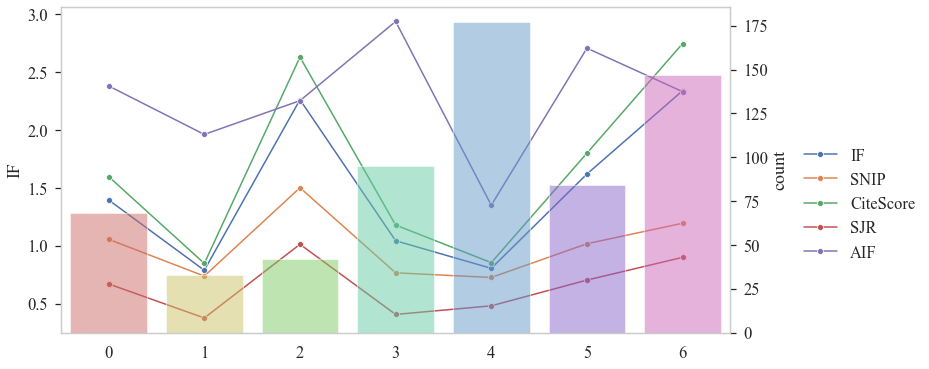

In [113]:
sns.set_theme(style="whitegrid", font_scale=1.5, font="Times New Roman")

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.grid(False)
IF = sns.lineplot(data = vidurkiai['IF'], marker='o', sort = False, ax=ax1)
ax2 = ax1.twinx()
ax2.grid(False)
SNIP = sns.lineplot(data = vidurkiai['SNIP'], marker='o', sort = False, ax=ax1)

CiteScore = sns.lineplot(data = vidurkiai['CiteScore'], marker='o', sort = False, ax=ax1)

SJR = sns.lineplot(data = vidurkiai['SJR'], marker='o', sort = False, ax=ax1)

AIF = sns.lineplot(data = vidurkiai['AIF'], marker='o', sort = False, ax=ax1)

sns.barplot(data = vidurkiai, x='clusters', y='count', alpha=0.5, ax=ax2, palette="hls");

ax1.legend(['IF', 'SNIP', 'CiteScore', 'SJR', 'AIF'], loc=(1.1,0.2));


#### Atrenkami top 10 leidinių, kurie buvo klasterizuojami ir patikrinama, kokiam klasteriui jie buvo priskirti

(Imama 17, o ne 10 leidinių, nes dalis iš daugiausiai minimų žurnalų nebuvo klasterizuojami, nes neturėjo bibliografinių rodiklių)

In [114]:
top_17 = pd.DataFrame(leidiniai['final_index'].value_counts()).head(17)

In [115]:
top_17 = top_17.reset_index().rename(columns = {'final_index':'value_count', 'index':'final_index'})

In [116]:
top10 = pd.merge(top_17,klasteriu_analize,on='final_index').drop_duplicates(subset='final_index', keep="last")

In [117]:
top10

,final_index,value_count,journal_name,scopus_sources,SNIP,CiteScore,SJR,quartile_in_caterory,IF,AIF,quartile_in_caterory_2,if_info_years,InCites_JCR,clusters
8,164.0,170,Elektronika ir elektrotechnika,2018,0.488,0.81,0.182,Q3,0.684,3.195,Q4,2018,SCIE,1
23,258.0,162,Journal of civil engineering and management,2018,0.895,2.05,0.585,Q2,0.000,0.000,0,0,0,2
40,74.0,126,The Baltic journal of road and bridge engineering,2018,0.625,0.85,0.300,Q3,0.771,2.693,Q4,2018,SCIE,1
55,62.0,121,Transport,2018,1.222,1.78,0.478,Q2,0.000,0.000,0,0,0,1
64,1298.0,120,Verslas: teorija ir praktika,2018,0.933,1.21,0.259,Q2,0.000,0.000,0,0,0,4
71,174.0,104,Sustainability,2018,1.169,3.01,0.549,Q1,0.000,0.000,0,0,0,2
83,443.0,104,Technological and economic development of economy,2018,1.399,3.76,0.774,Q1,0.000,0.000,0,0,0,2
99,191.0,101,Filosofija. Sociologija,2018,0.304,0.36,0.637,Q2,0.403,1.636,Q4,2018,SSCI,1
108,334.0,98,Logos,2018,0.027,0.03,0.154,Q4,0.000,0.000,0,0,0,4
117,870.0,92,Journal of business economics and management,2018,0.637,1.75,0.389,Q2,1.855,2.590,Q2,2018,SSCI,1


#### Flask modelio kūrimas, naudojant prieš tai atskirtus duomenis.

#### dummy modelis deploymentui

In [118]:
test_data_for_flask

,2018_SNIP,2018_CiteScore,2018_SJR,2018_scopus_quartile,2018_AIF,2018_IF_quartile
358,0.000,0.00,0.000,0.0,0.000,0.0
360,0.558,1.51,0.534,2.0,3.556,3.0
442,0.000,0.00,0.000,0.0,0.000,0.0
443,1.433,7.19,1.947,1.0,5.322,1.0
451,0.000,0.00,0.000,0.0,0.000,0.0
...,...,...,...,...,...,...
244,0.000,0.00,0.000,0.0,0.000,0.0
242,1.131,2.57,0.438,2.0,3.514,3.0
241,1.095,3.99,1.455,1.0,3.989,2.0
645,0.758,1.24,0.422,2.0,1.891,3.0


In [119]:
km_1 = KMeans(random_state=43)

In [120]:
km_1.fit(test_data_for_flask)

KMeans(random_state=43)

#### Naudojant kelbow_visualizer, patikrinama, koks klasterių skaičius tinkamiausias šiems duomenims. Gautas rezultatas – 5

In [126]:
test_data_for_flask.describe()

,2018_SNIP,2018_CiteScore,2018_SJR,2018_scopus_quartile,2018_AIF,2018_IF_quartile
count,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000
mean,0.564006,1.341652,0.406715,0.900433,1.801961,1.229437
std,0.679707,1.909336,0.655651,1.065552,1.937946,1.448823
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.374500,0.500000,0.190000,1.000000,0.917000,1.000000
75%,1.008500,2.147500,0.571125,2.000000,3.534000,2.000000
max,3.694000,14.580000,5.646000,4.000000,5.878000,4.000000


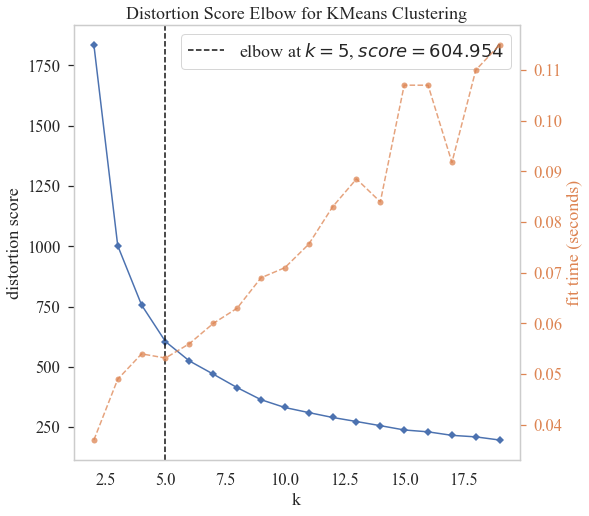

In [121]:
sns.set_theme(style="whitegrid", font_scale=1.5, font="Times New Roman")
f, ax = plt.subplots(figsize=(8,8))
ax.grid(False)

viz = kelbow_visualizer(KMeans(), test_data_for_flask, k=(2, 20), show=False, random_state=43)

In [122]:
km_2 = KMeans(n_clusters=5, random_state=43)

In [123]:
km_2.fit(test_data_for_flask)

KMeans(n_clusters=5, random_state=43)

In [124]:
filename = 'finalized_model.sav'
print("saving the model")
pickle.dump(km_2, open(filename, 'wb'))

saving the model
